In [1]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from llama import get_model_and_tokenizer

In [2]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## RL helper functions

In [3]:
from rl_utils import gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 

## Discrete Env RL helper functions

In [4]:
from rl_disc_utils import make_RL_time_serie_discrete, build_transition_matrix, build_baseline_transition_matrix, kl_div, compute_statistics_discrete, compute_statistics_discrete_policy, plot_diff   

## DP solvers

In [5]:
from dynamic_programming import compute_optimal_policy

## Random MDPs Env

In [6]:
class RandomTabularMDP(gym.Env):
    def __init__(self, num_states, num_actions):
        super().__init__()
        self.num_states = num_states
        self.num_actions = num_actions

        # Initialize transition probabilities randomly
        self.transition_matrix = np.random.rand(num_states, num_actions, num_states)
        self.transition_matrix /= np.sum(self.transition_matrix, axis=2, keepdims=True)

        # Initialize random reward vector
        self.reward_vector = np.random.rand(num_states, num_actions)

        # Set initial state
        self.current_state = np.random.randint(num_states)

        # Define action space and observation space
        self.action_space = gym.spaces.Discrete(num_actions)
        self.observation_space = gym.spaces.Discrete(num_states)

    def step(self, action):
        next_state = np.random.choice(self.num_states, p=self.transition_matrix[self.current_state, action])
        reward = self.reward_vector[self.current_state, action]
        terminated = False
        truncated = False
        self.current_state = next_state
        return next_state, reward, terminated, truncated, {}

    def reset(self):
        self.current_state = np.random.randint(self.num_states)
        return self.current_state, {}

def generate_trajectory(env, policy, n_steps):
    """
    Generates an N-step trajectory using the given policy.

    Args:
        env (gym.Env): The environment.
        policy (callable): A function that takes an observation and returns an action.
        n_steps (int): Number of steps in the trajectory.

    Returns:
        list: List of (state, action, reward, next_state) tuples.
    """
    trajectory = []
    obs = env.reset()
    for _ in range(n_steps):
        action = policy(obs)
        next_obs, reward, done, _ = env.step(action)
        trajectory.append((obs, action, reward, next_obs))
        if done:
            break
        obs = next_obs
    return trajectory

# Example usage:
# if __name__ == "__main__":
#     # Create an instance of your RandomTabularMDP environment
#     env = RandomTabularMDP(num_states=10, num_actions=4)

#     # Define a random policy (e.g., always take action 0)
#     def random_policy(obs):
#         return env.action_space.sample()

#     n_steps = 5
#     trajectory = generate_trajectory(env, random_policy, n_steps)
#     for step, (state, action, reward, next_state) in enumerate(trajectory):
#         print(f"Step {step + 1}: State={state}, Action={action}, Reward={reward}, Next State={next_state}")


In [7]:
def gym_generate_deterministic_policy(env: gym.Env, policy: np.array, Number_of_steps: int = 200, seed: int = 7):
    env.np_random.__setstate__(np.random.default_rng(seed).__getstate__())

    obs, _ = env.reset()

    observations = []
    actions = []
    rewards = []
    terminateds = []
    truncateds = []
    # Generate the episode
    for t in range(Number_of_steps):
        action = policy[obs]
        
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        observations.append(np.array(obs).reshape(1,-1))
        actions.append(np.array(action).reshape(1,-1))
        rewards.append(np.array(reward).reshape(1,-1))
        terminateds.append(np.array(terminated).reshape(1,-1))
        truncateds.append(np.array(truncated).reshape(1,-1))
        
        if terminated or truncated:
            observations.append(np.array(next_obs).reshape(1,-1))
            none_action = np.empty(np.array(action).reshape(1,-1).shape)
            none_action[:] = np.nan
            actions.append(none_action)
            none_reward = np.empty(np.array(reward).reshape(1,-1).shape)
            none_reward[:] = np.nan
            rewards.append(none_reward)
            none_terminated = np.empty(np.array(terminated).reshape(1,-1).shape)
            none_terminated[:] = np.nan
            terminateds.append(none_terminated)
            none_truncated = np.empty(np.array(truncated).reshape(1,-1).shape)
            none_truncated[:] = np.nan
            truncateds.append(none_truncated)
            obs, _ = env.reset()
        else:
            obs = copy.copy(next_obs)

    observations = np.stack(observations, axis=0).reshape((-1, 1))
    actions = np.stack(actions, axis=0).reshape((-1, 1))
    rewards = np.stack(rewards, axis=0).reshape((-1, 1))

    X = np.concatenate([observations, actions, rewards], axis=1)
    return X

In [8]:
N = 200
env = RandomTabularMDP(num_states=8, num_actions=2)

N_states = env.observation_space.n
state_dim = 1
action_dim = 1
add_actions = False

# -------------------- Compute true transition matrix --------------------
P, R = env.transition_matrix, env.reward_vector

fixed_random_policy = np.random.randint(low=0, high=env.action_space.n, size=(N_states, ))

expert_policy, iteration = compute_optimal_policy(T=P, R=R, gamma=0.99, algo='VI')
print(f"optimal policy found after {iteration} iterations")

optimal policy found after 488 iterations


In [69]:
policy_type = 'expert'  # 'random_fixed', 'random', 'expert'

# -------------------- Build data from env --------------------
if policy_type == 'random':
    X = gym_generate_random_policy(env=env, Number_of_steps=N)
elif policy_type == 'random_fixed':
    X = gym_generate_deterministic_policy(env=env, policy=fixed_random_policy, Number_of_steps=N)
elif policy_type=='expert':
    X = gym_generate_deterministic_policy(env=env, policy=expert_policy, Number_of_steps=N)
else:
    raise ValueError(f"policy_type {policy_type} not supported!")

# -------------------- Make RL time serie --------------------
series_dict= make_RL_time_serie_discrete(
    X=X, 
    Number_of_steps=N,
    traj_starting_idx=0,
    add_actions=add_actions,
)

# -------------------- ICL prediction using llama3 --------------------
series_dict = icl_prediction(
    model=model, tokenizer=tokenizer, series_dict=series_dict, temperature=1.0, n_states=N_states,
    save=False,
)

# -------------------- Compute true transition matrix --------------------
series_dict['true_P'] = P
P_baseline = build_baseline_transition_matrix(N_states, env.action_space.n, series_dict['full_series'].split(','), series_dict['actions'], add_actions=add_actions)
series_dict['baseline_P'] = P_baseline

# -------------------- Compute statistics of next state --------------------
series_dict, statistics = compute_statistics_discrete_policy(
    series_dict=series_dict,
    policy=fixed_random_policy if policy_type == 'random_fixed' else expert_policy,
    add_actions=add_actions,
)

full_series: 7,7,7,4,3,1,7,2,7,3,0,2,6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 7724.75it/s]

true probability matrix P: (8, 2, 8)


norm_baseline: 0.8389849144450401


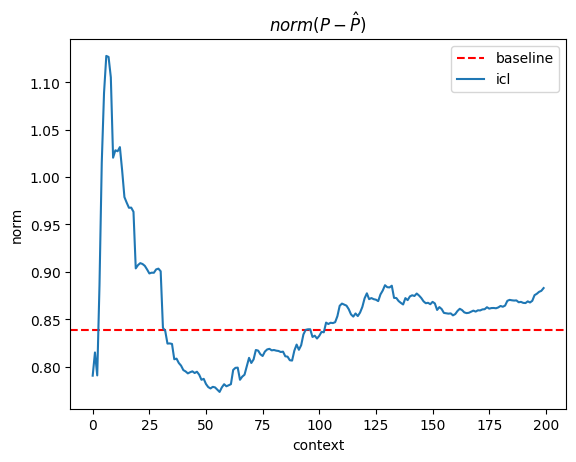

In [70]:
norm_baseline= np.linalg.norm(series_dict['true_P']-series_dict['baseline_P'])
print(f"norm_baseline: {norm_baseline}")
x = np.arange(len(statistics['P_diff']))
plt.figure()
plt.axhline(y=norm_baseline, xmin=x[0], xmax=x[-1], color='r', linestyle='--', label='baseline')
plt.plot(statistics['P_diff'], label='icl')
plt.title(r"$norm(P-\hat{P})$")
plt.xlabel("context")
plt.ylabel("norm")
plt.legend()
plt.show()

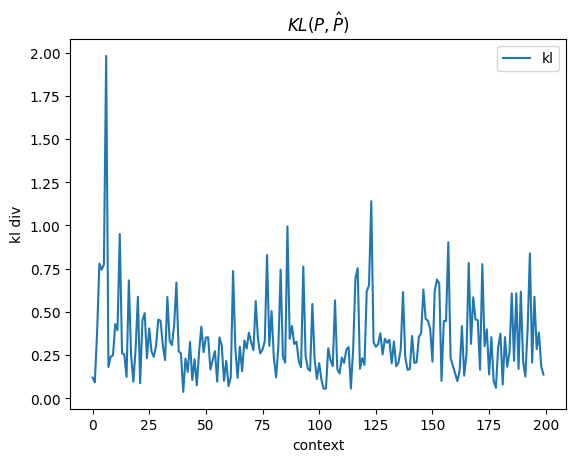

In [58]:
x = np.arange(len(statistics['discrete_KL_loss']))
plt.figure()
plt.plot(x, statistics['discrete_KL_loss'], label='kl')
plt.title(r"$KL(P,\hat{P})$")
plt.xlabel("context")
plt.ylabel("kl div")
plt.legend()
plt.show()

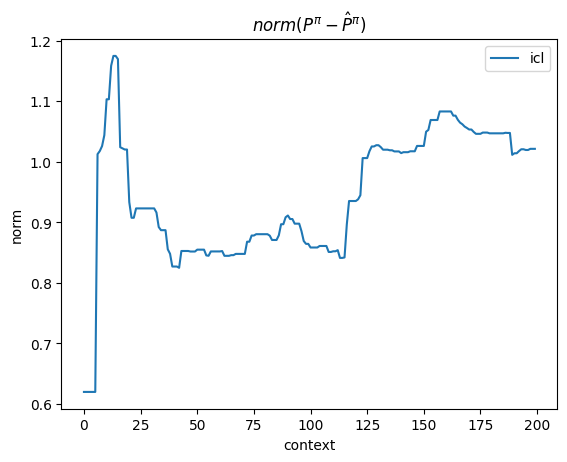

In [59]:
# norm_baseline= np.linalg.norm(series_dict['true_P']-series_dict['baseline_P'])
# print(f"norm_baseline: {norm_baseline}")
x = np.arange(len(statistics['P_pi_diff']))
plt.figure()
# plt.axhline(y=norm_baseline, xmin=x[0], xmax=x[-1], color='r', linestyle='--', label='baseline')
plt.plot(statistics['P_pi_diff'], label='icl')
plt.title(r"$norm(P^\pi-\hat{P}^\pi)$")
plt.xlabel("context")
plt.ylabel("norm")
plt.legend()
plt.show()

/tmp/ipykernel_4079680/1891197384.py:47: RuntimeWarning: divide by zero encountered in log
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim
/tmp/ipykernel_4079680/1891197384.py:47: RuntimeWarning: invalid value encountered in multiply
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim


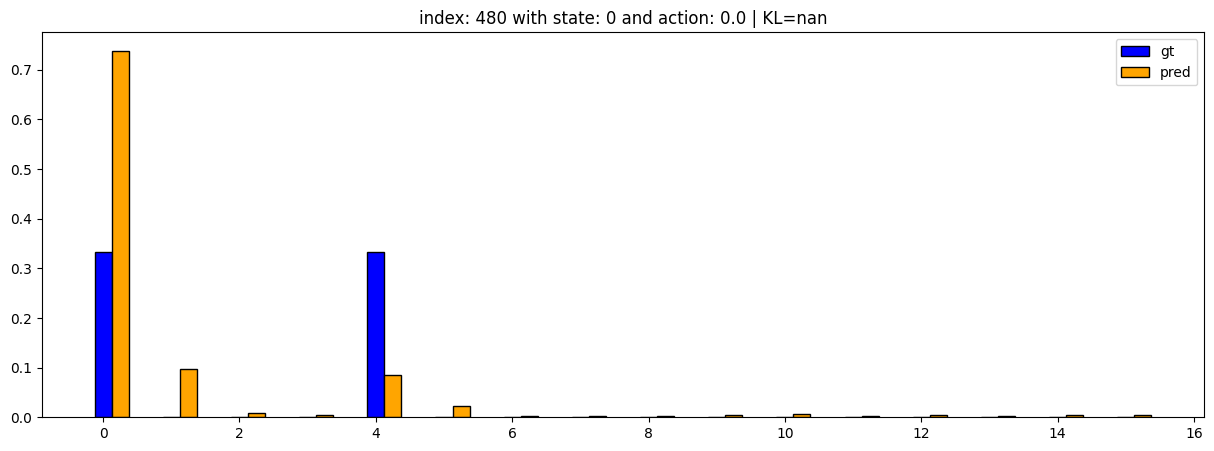

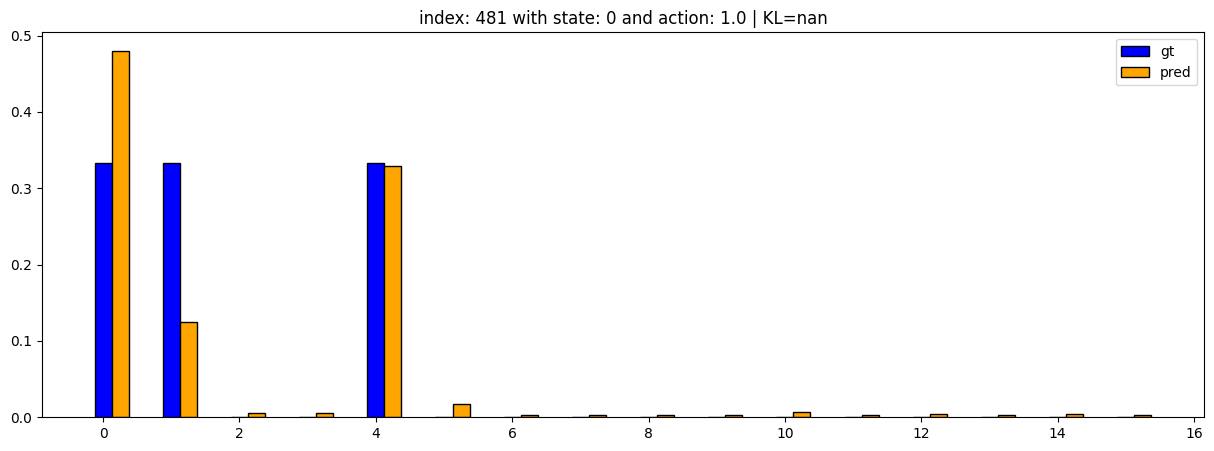

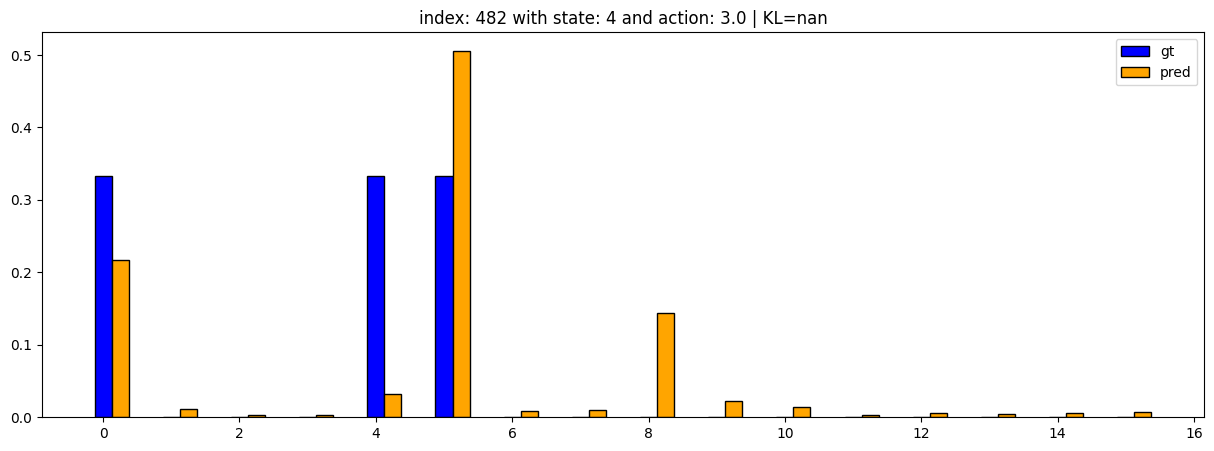

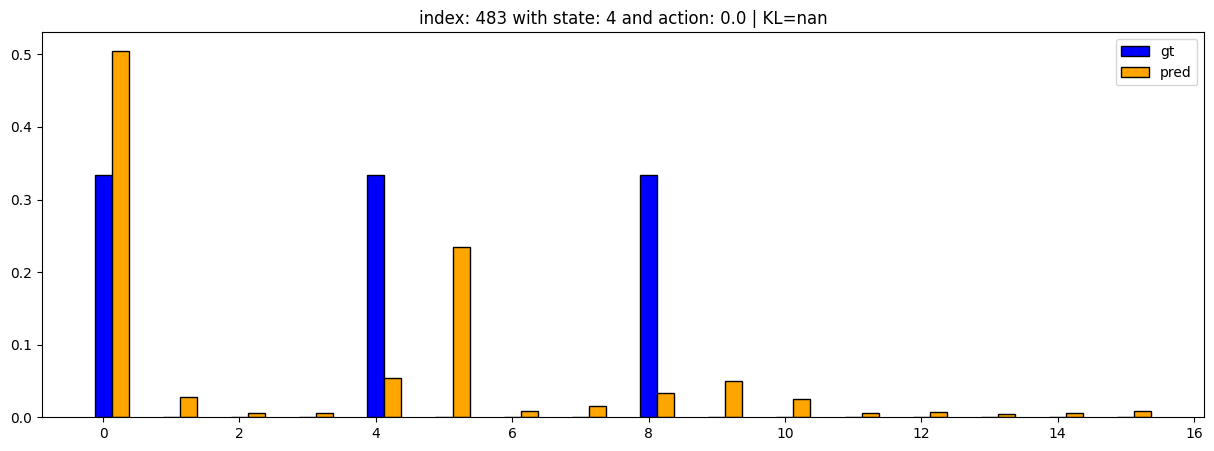

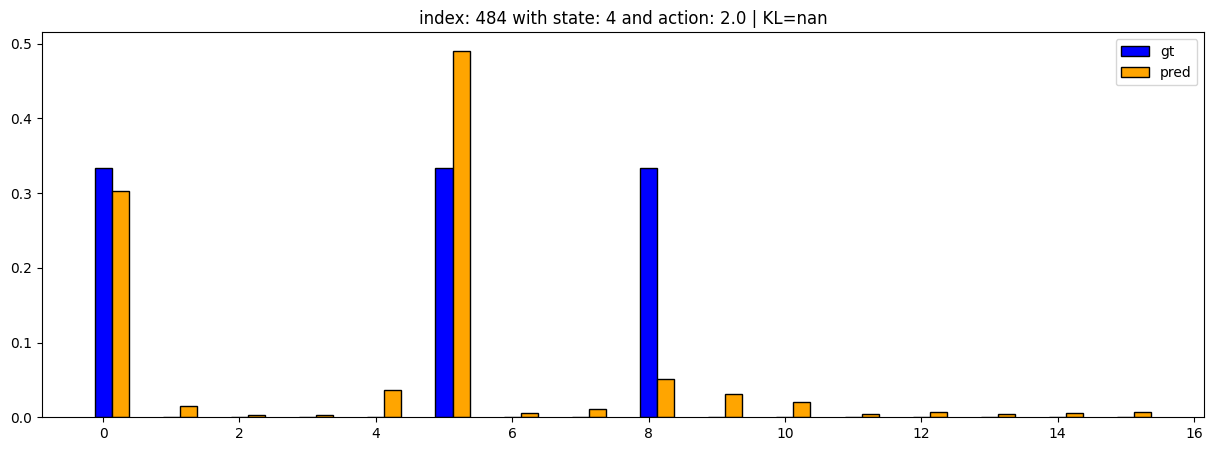

terminal state


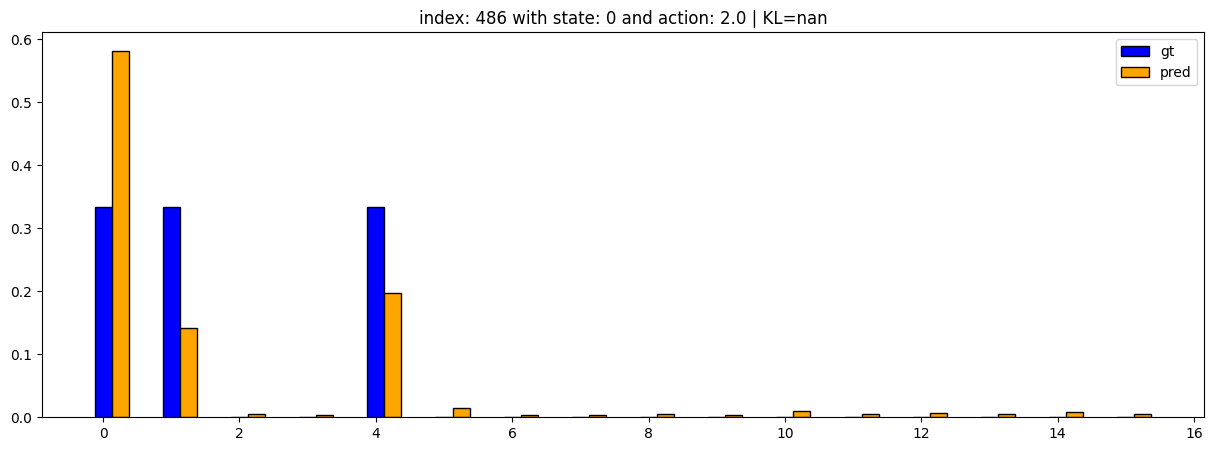

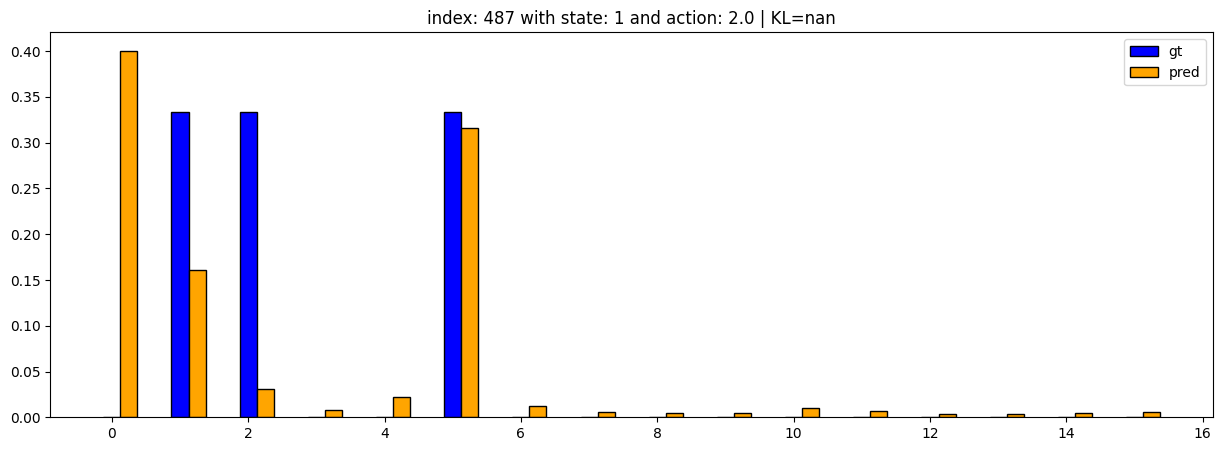

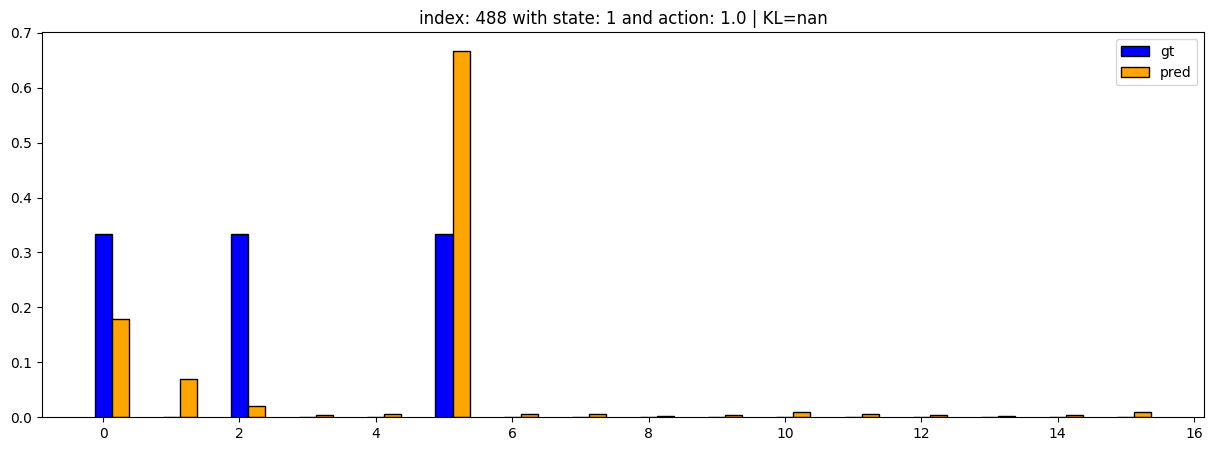

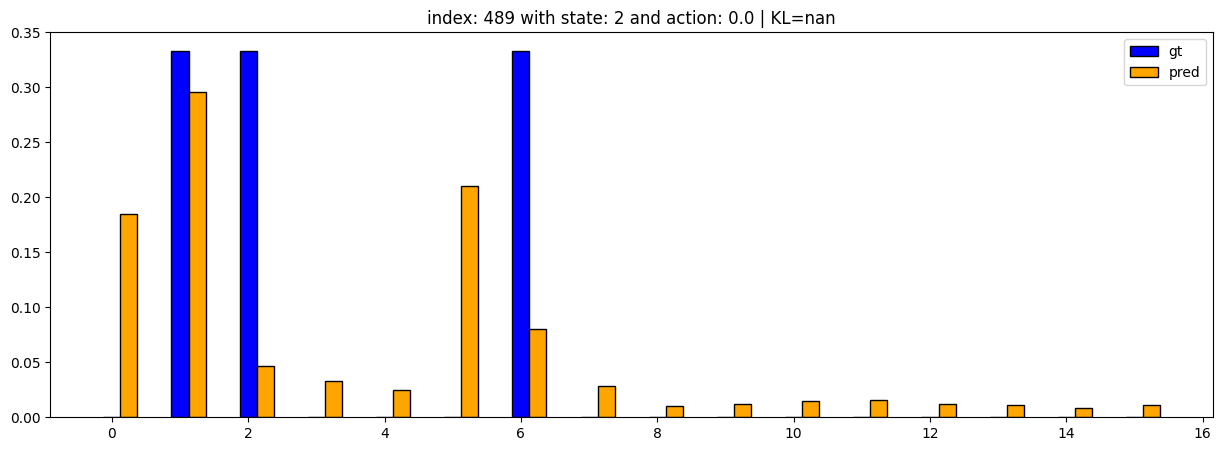

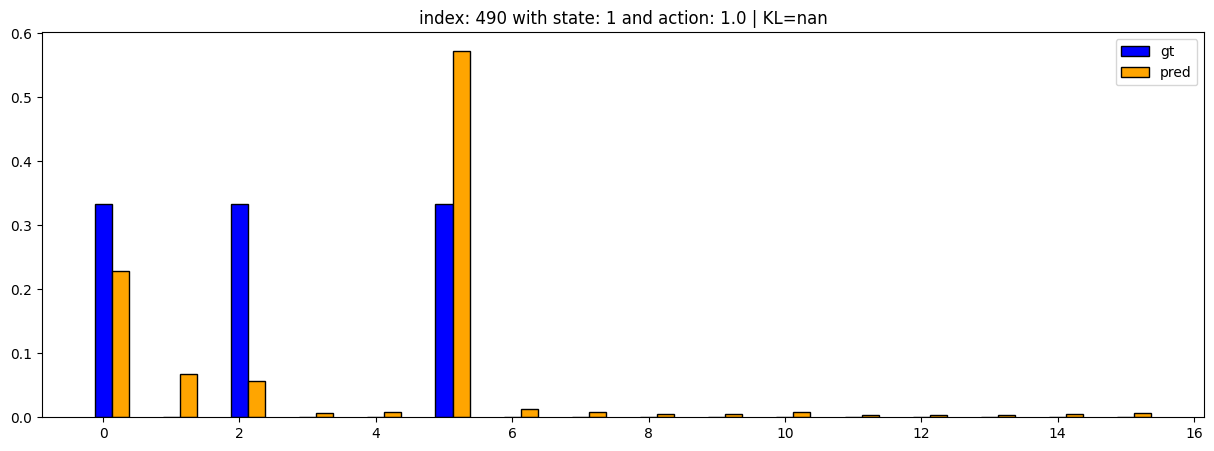

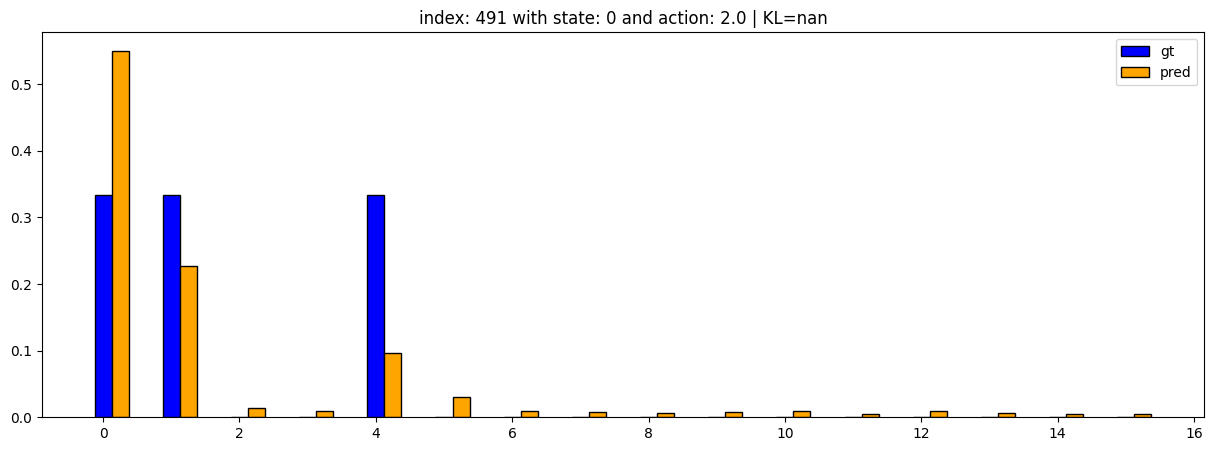

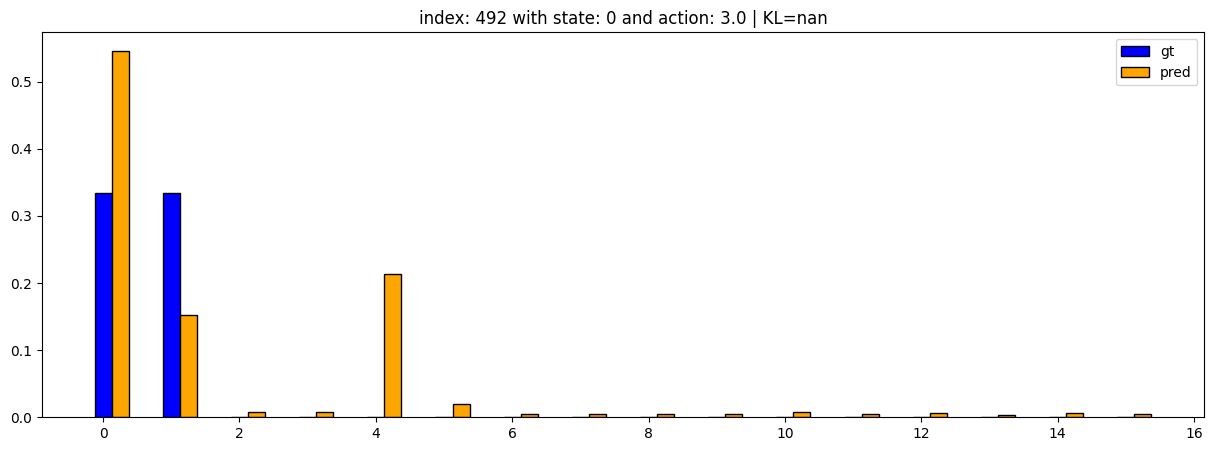

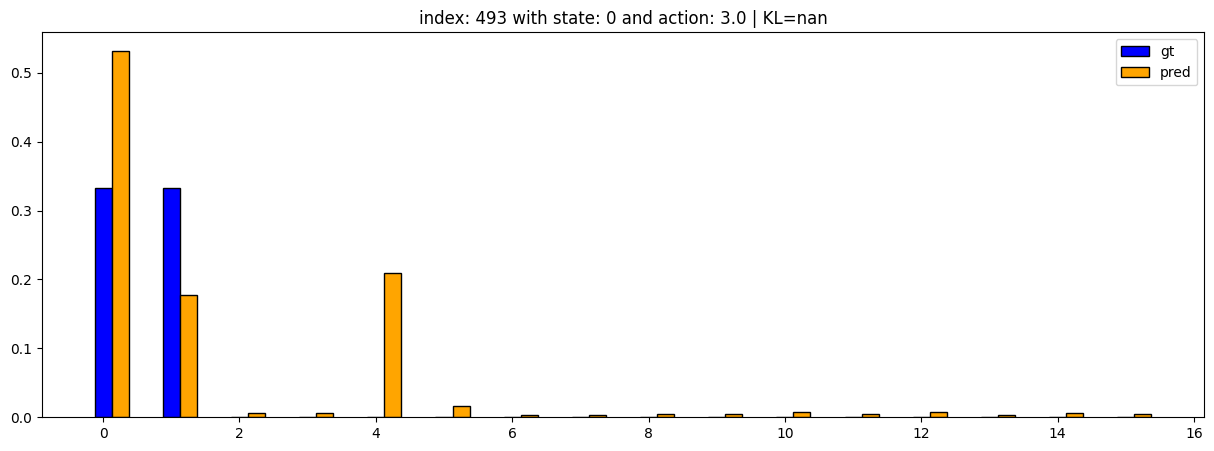

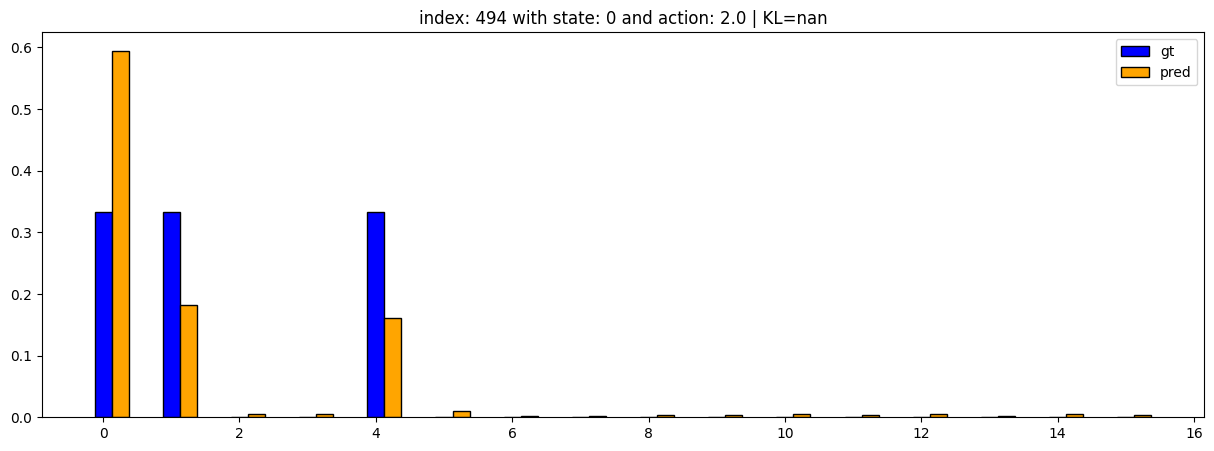

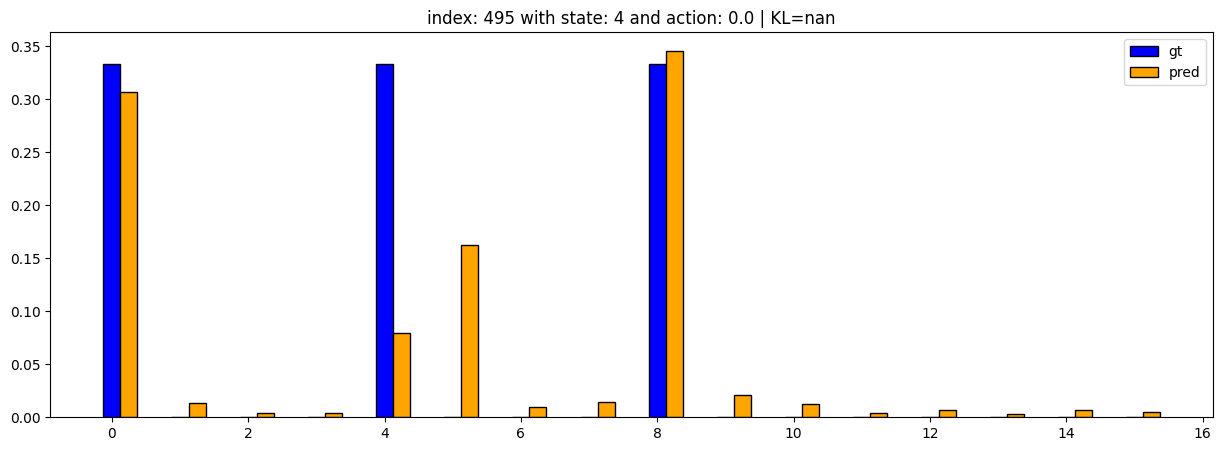

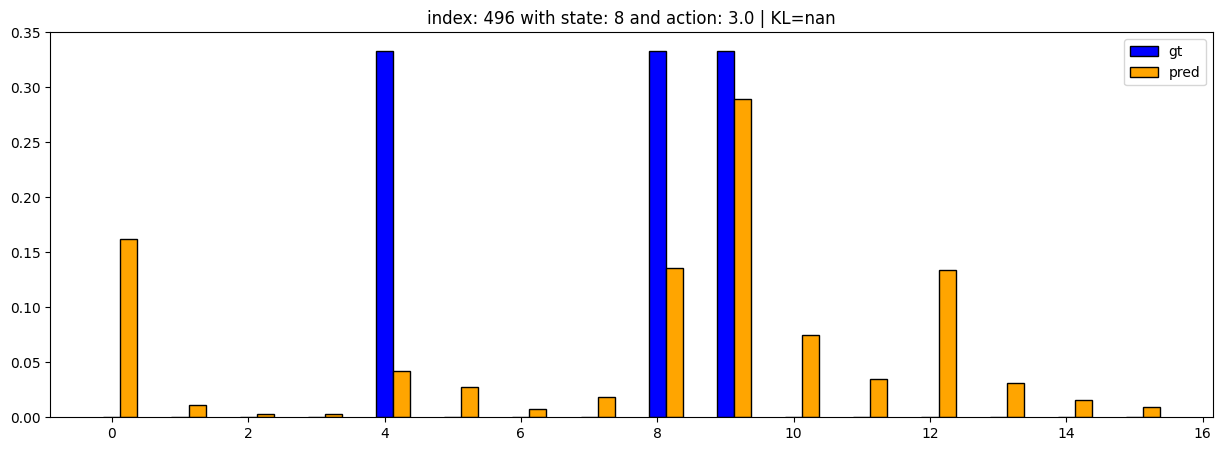

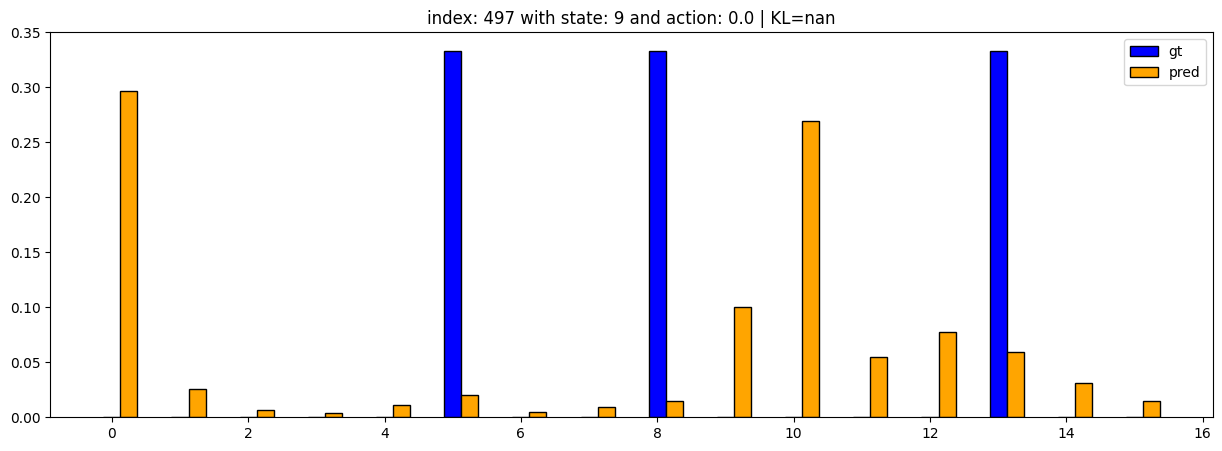

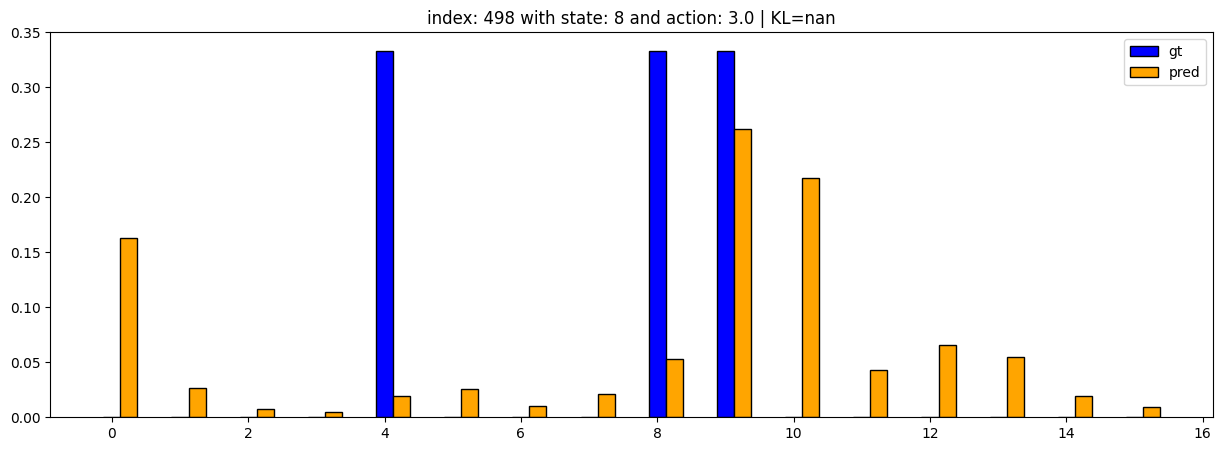

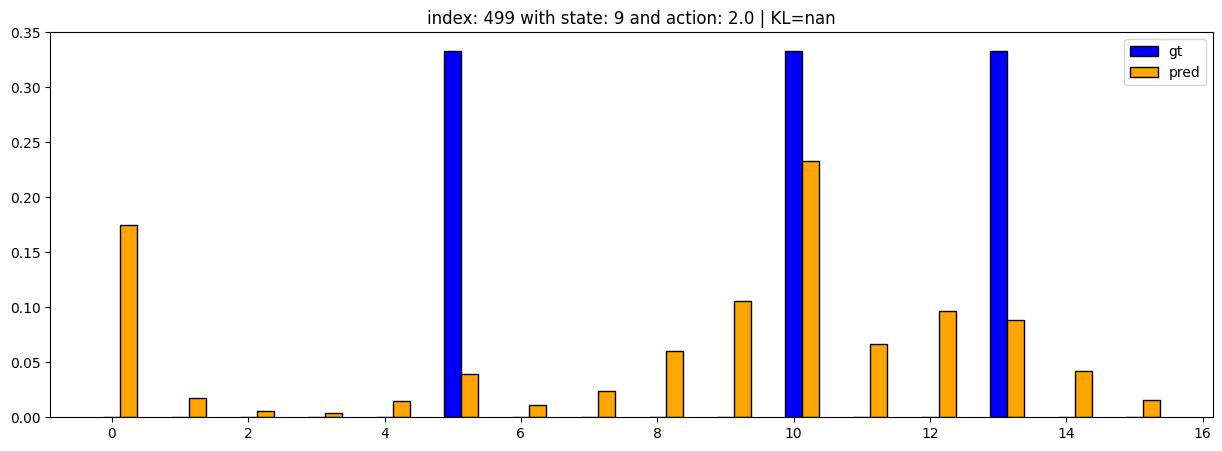

In [187]:
plot_diff(series_dict, indices=np.arange(480, 500))

## Non-Markovian

In [9]:
s0 = 1
s1 = 1
coeff1 = 

full_series: 2,4,3,7,5,3,2,4,0,3,6,5,4


{'full_series': '2,4,3,7,5,3,2,4,0,3,6,5,4,0,6,0,1,3,0,0,6,7,5,3,1,2,3,2,1,1,6,5,4,1,6,4,1,6,5,5,0,5,5,1,7,6,7,0,0,0,3,3,2,4,5,1,2,6,1,2,5,1,6,5,7,3,3,7,5,1,2,1,2,4,7,4,6,7,6,1,2,4,6,5,7,2,3,7,6,5,2,0,7,4,1,2,1,2,7,6,5,1,3,7,3,0,3,7,5,4,6,3,2,5,6,7,3,7,3,5,1,4,3,7,7,2,7,3,2,7,3,7,3,3,7,3,2,3,3,3,2,7,0,7,0,6,1,6,6,5,1,2,1,5,1,6,6,4,0,0,5,5,4,6,6,0,3,5,7,4,0,4,7,4,0,3,2,0,0,5,3,7,6,6,6,4,7,4,0,0,0,3,2,7,0,0,5,1,5,4',
 'actions': array([1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 1., 1.

## Average

In [ ]:
N = 200
for _ 
env = RandomTabularMDP(num_states=8, num_actions=2)

N_states = env.observation_space.n
state_dim = 1
action_dim = 1
add_actions = False

# -------------------- Compute true transition matrix --------------------
P, R = env.transition_matrix, env.reward_vector

fixed_random_policy = np.random.randint(low=0, high=env.action_space.n, size=(N_states, ))

expert_policy, iteration = compute_optimal_policy(T=P, R=R, gamma=0.99, algo='VI')
print(f"optimal policy found after {iteration} iterations")

## Matrix completion

In [22]:
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [23]:
comma_locations = np.sort(np.where(np.array(list(series_dict['full_series'])) == ',')[0])
ns = create_ns(series_dict['full_series'], comma_locations)
bins_ = bins_completion(series_dict['PDF_list'])

In [43]:
series_dict['full_series']

'150,150,150,150,150,150,150,150,365,365,150,365,365,580,365,365,365,365,419,150,150,150,203,150,150,203,150,203,257,311,257,311,257,473,419,150,150,365,580,365,150,150,365,580,634,850,634,580,796,150,150,150,150,150,365,580,580,634,688,742,150,203,150,150,203,257,473,526,150,150,365,580,580,580,796,150,150,150,203,203,419,150,150,365,419,150,365,580,634,688,742,150,150,203,150,365,580,365,580,796,'

In [42]:
sorted(set(series_dict['full_series']))

[',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [26]:
ps, hashmap = completion_matrix_ot_breg(bins_,ns,statistics['discrete_BT_loss'], reg=5e-3)
ps2, hashmap2 = completion_matrix(bins_,ns,statistics['discrete_BT_loss'])

/home/abenechehab/llmICL/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(non_zero_sums_mask, np.true_divide(prob, row_sums), prob)


after filling: 0
fill borders: 0
after normalize: 0
fill borders 2: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.07s/it]


after ot: 0
after last normalize: 0


<BarContainer object of 1000 artists>

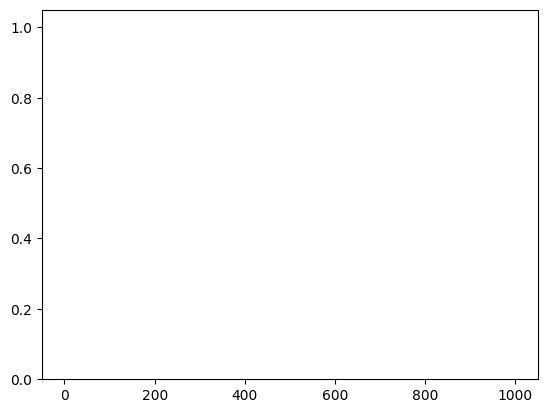

In [28]:
plt.bar(np.arange(1000), ps[5])

OT completion


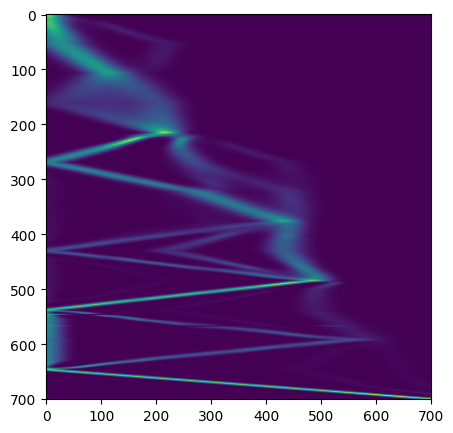

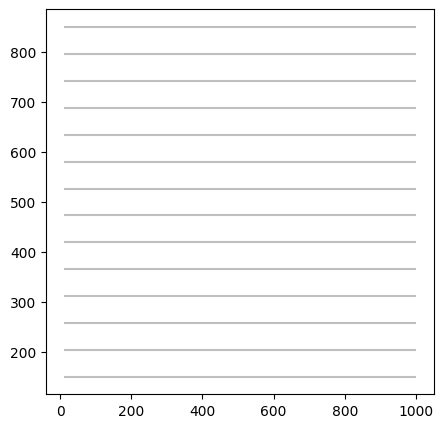

No completion


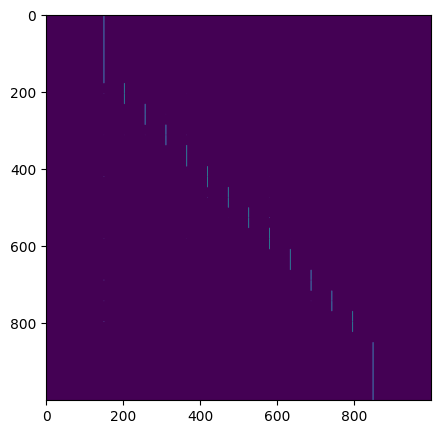

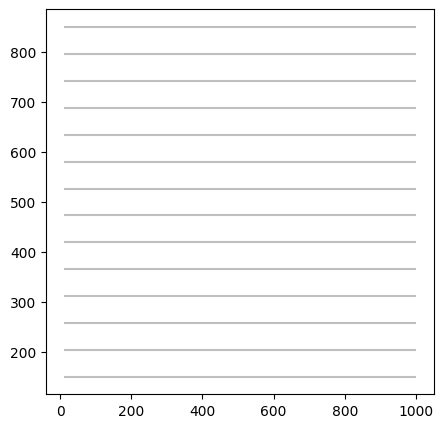

In [29]:
print(f"OT completion")
plt.figure(figsize=(5,5))
plt.imshow(ps[149:850,149:850])
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap)
plt.show()

print(f"No completion")
plt.figure(figsize=(5,5))
plt.imshow(ps2)
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap2)
plt.show()

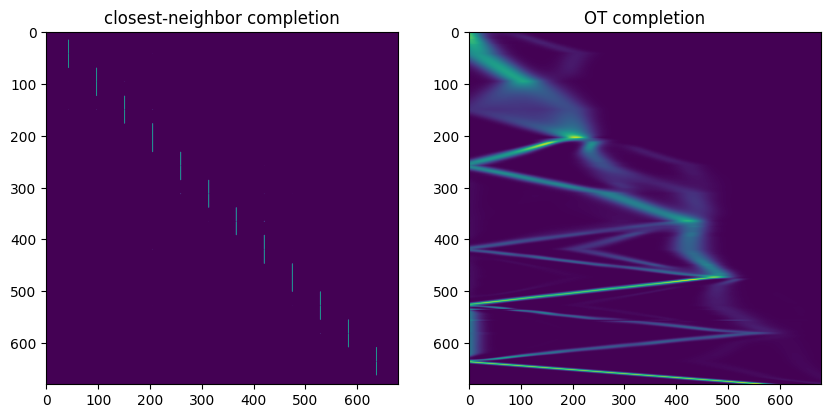

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ps2[160:840,160:840])
plt.title("closest-neighbor completion")

plt.subplot(1,2,2)
plt.imshow(ps[160:840,160:840])
plt.title("OT completion")

plt.show()

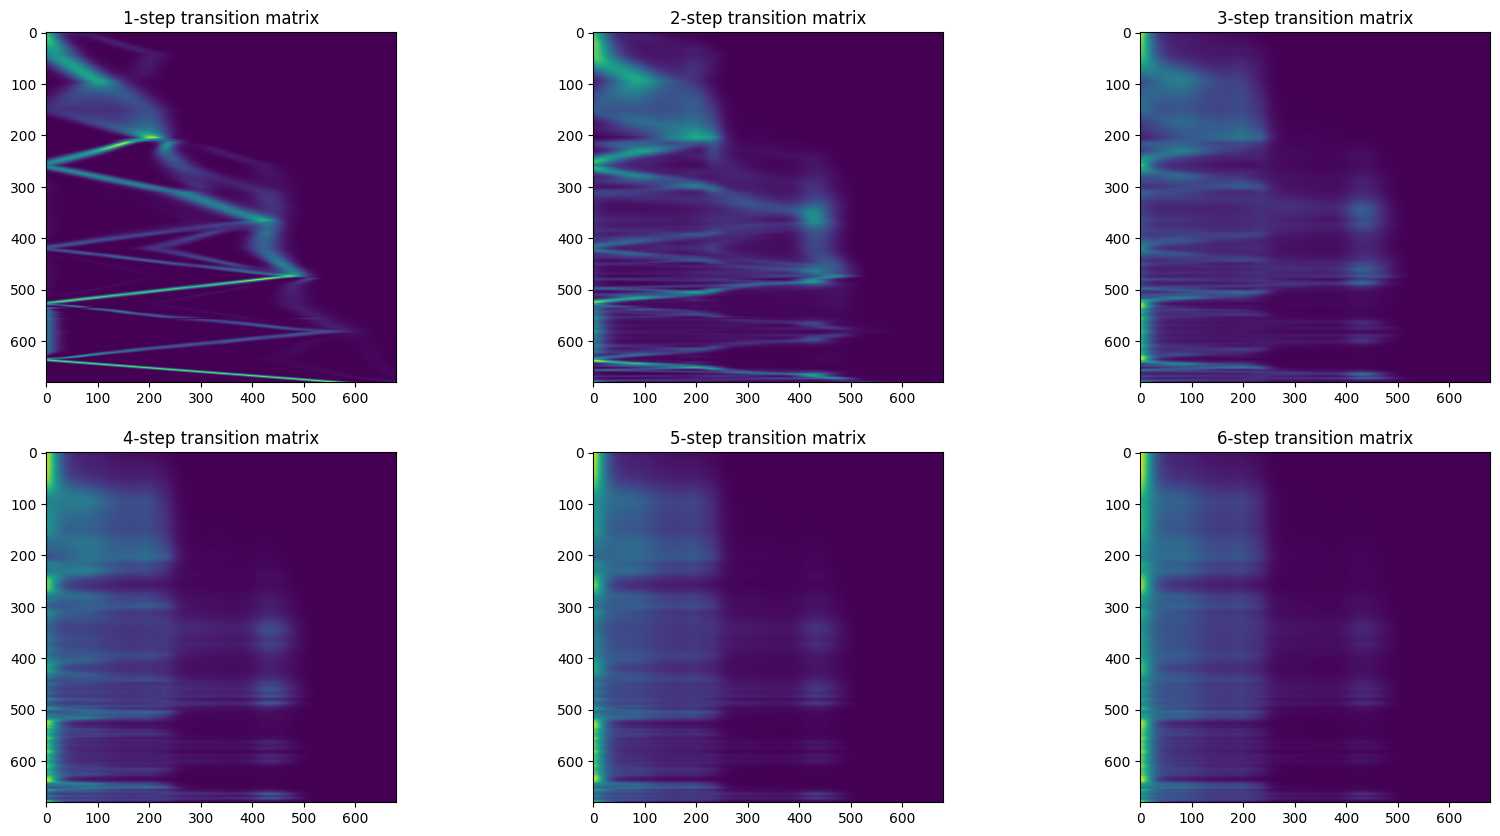

In [31]:
plt.figure(figsize=(20,10))
for power in range(1,7):
    plt.subplot(2,3,power)
    plt.imshow(np.linalg.matrix_power(ps,power)[160:840,160:840])
    plt.title(f"{power}-step transition matrix")
plt.show()

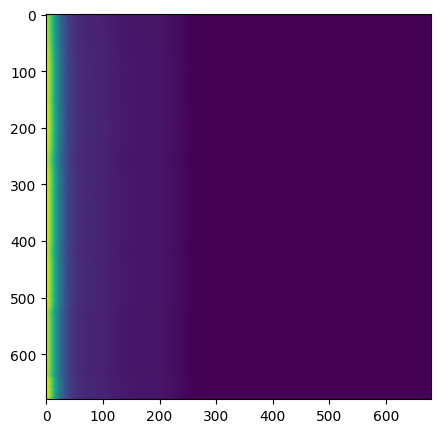

In [41]:
plt.figure(figsize=(5,5))
plt.imshow(np.linalg.matrix_power(ps,2000)[160:840,160:840])
plt.show()